In [ ]:
# Checking life expectancy for countries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [115]:
df = pd.read_csv('refined_life_expect.csv')
print(df.shape)

#remove fragmanted data
df.dropna(inplace=True)

# make sure that there's still enough data to work with
print(df.shape)

(2938, 20)
(1649, 20)


In [83]:
# # remove 1% from the tail ends of our the data for life expectancy
# IQR = [df.life_expectancy.quantile(0.99), df.life_expectancy.quantile(0.01)]
# df = df[df.life_expectancy < IQR[0]] 
# df = df[df.life_expectancy > IQR[1]] 
# print(df.shape)

(1605, 19)


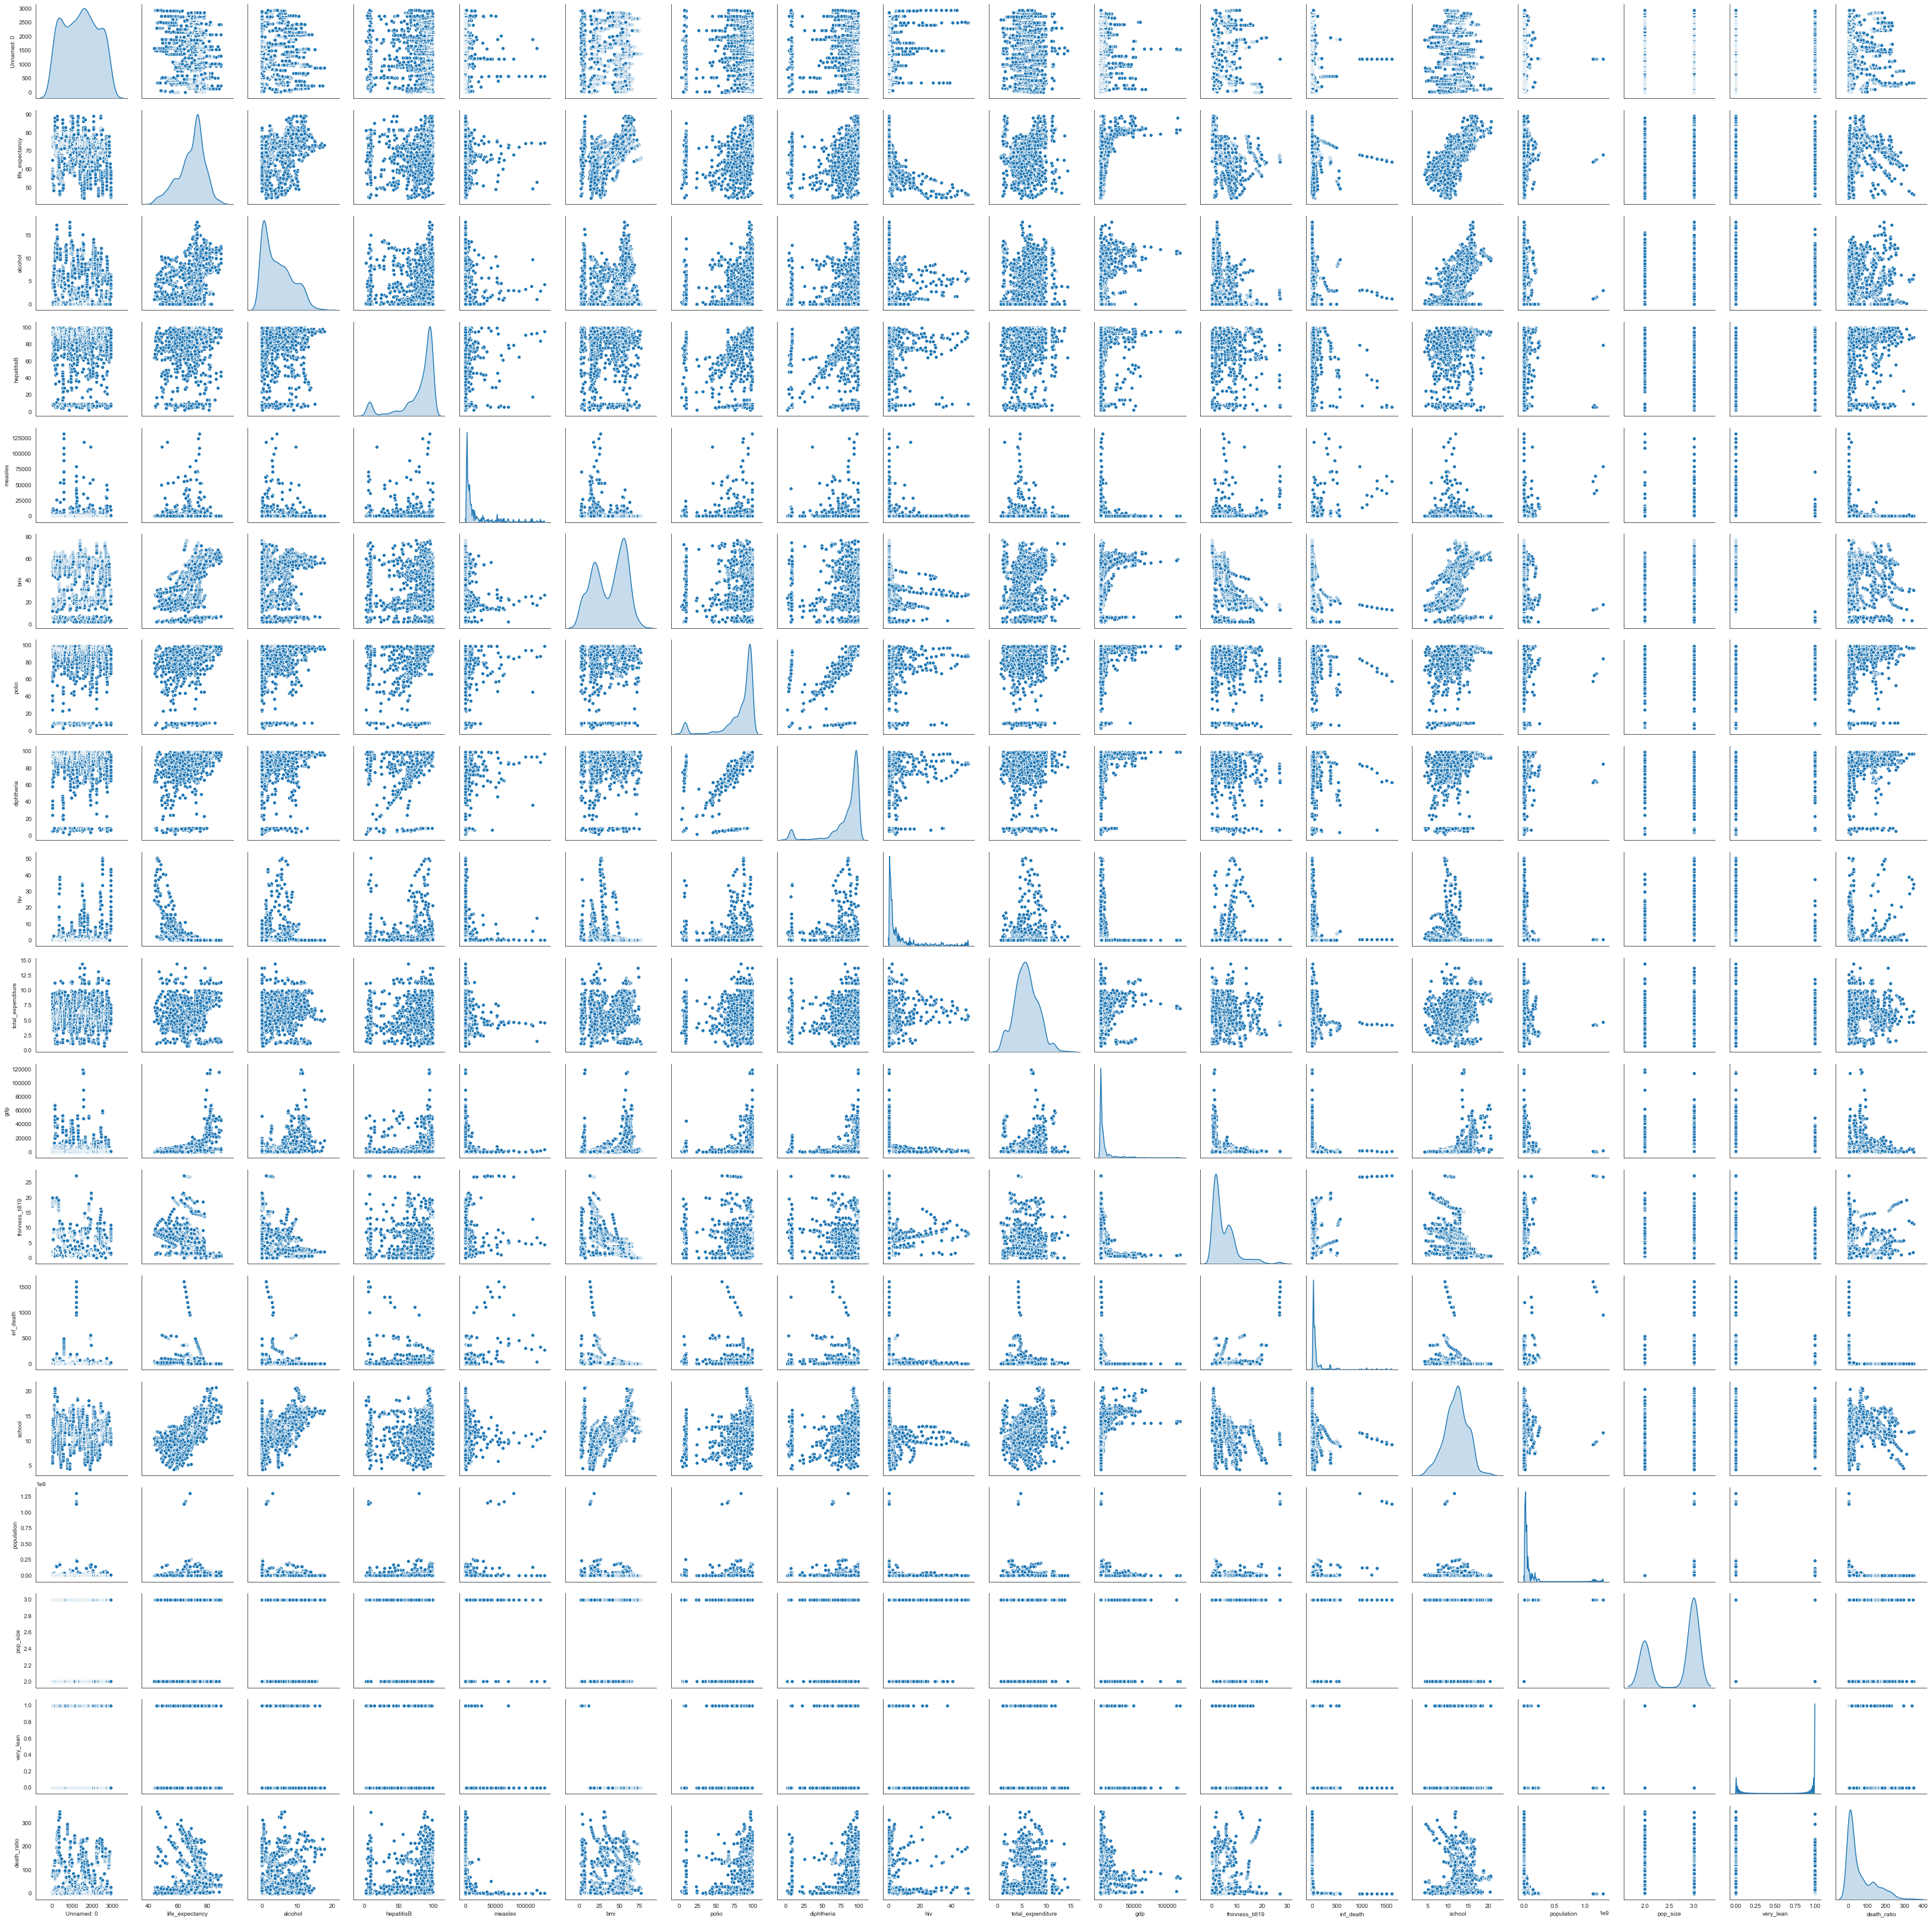

In [116]:
# check for correlations between the different variables
sns.pairplot(df, diag_kind="kde", height=2.5)

In [117]:
# from the paired plot using the columns we believe alcohol, bmi, hiv, gdp, 
# how thin, schooling, how big the countries, the ratio between adult to infant mortality,
#the interactions between bmi+alcohol (lifestyle), the interaction between population+gdp, 
#and if the country is big/medium/small

new_df = pd.DataFrame({'life_expectancy': df['life_expectancy'],
                        'alcohol': df['alcohol'],
                        'bmi': df['bmi'],
                        'hiv': df['hiv'],
                        'gdp': df['gdp'],
                        'thinness_till19': df['thinness_till19'],
                        'inf_death': df['inf_death'],
                        'school': df['school'],
                        'death_ratio': df['death_ratio'],
                        'lifestyle': df['bmi']*df['alcohol'],
                        'pop_gdp': df['gdp']*df['pop_size'],
                        'pop_size': df['pop_size'],
                        'lean': df['very_lean']*df['bmi']
                        })

# check for multicollinearity and remove highgly correlated variables
corr_map = new_df.corr()

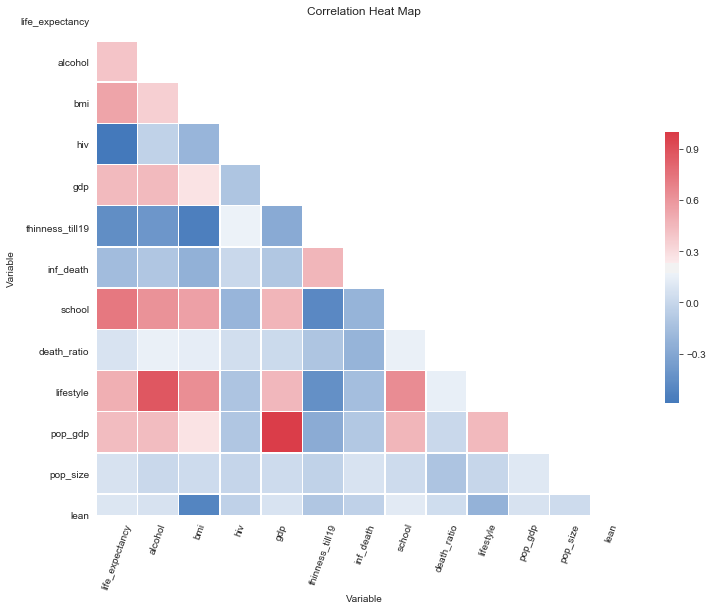

In [118]:
def CorrMtx(df, dropDuplicates = True, xrot=70, yrot=0, label='Variable'):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    # add titles
    plt.title("Correlation Heat Map")
   
    

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xlabel(label)
        plt.ylabel(label)
        plt.xticks(rotation=xrot)
        plt.yticks(rotation=yrot)
        
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xlabel(label)
        plt.ylabel(label)
        plt.xticks(rotation=xrot)
        plt.yticks(rotation=yrot)
    return

CorrMtx(corr_map)

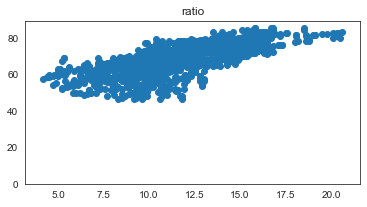

In [112]:
def create_hist(data, transform=None, title=None):
    if transform == 'log':
        data = np.log(data)
    elif transform == 'sqrt':
        data = np.cbrt(data)
    elif transform == 'cube':
        data = np.cbrt(data)
    
    plt.figure(figsize=(6,3))
    plt.hist(data, density=True)
    plt.title(title)
    plt.show
    return

create_hist(new_df['school'], transform=None ,title="ratio")
plt.scatter(new_df['school'], new_df['life_expectancy'])

In [ ]:
colors = ['red','blue','green','black','orange','purple','pink']
count=0
for region in list(zip(data['Region'].unique(),colors)):
    plots = sns.jointplot(x='relative_country_income',
                  y='Average Primary School Completion',
                  data=data[data['Region']==region[0]],
                  color=region[1], label=region[0], kind='reg',
                  ylim=(0,140))
    plots.fig.suptitle('Income vs Primary School Completion in '+region[0],y=1.03,fontsize=20)
    plots.annotate(stats.pearsonr)
    count+=1

In [ ]:
y = new_df.life_expectancy

xhiv = np.log(new_df['hiv'])
xalco = new_df['alcohol']
xbmi = new_df['bmi']
xgdp = np.log(new_df['gdp'])
xinf = np.cbrt(new_df['inf_death'])
xthin = new_df['thinness_till19']
def create_subplot(type='hist', data, rows=1, columns=1)
fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(xhiv)
axs[0, 0].set_title('Axis [0,0]')

axs[0, 1].hist(xbmi)
axs[0, 1].set_title('Axis [0,1]')

axs[0, 2].hist(xgdp)
axs[0, 2].set_title('Axis [0,1]')

axs[1, 0].hist(xalco)
axs[1, 0].set_title('Axis [1,0]')

axs[1, 1].hist(xinf)
axs[1, 1].set_title('Axis [1,1]')

axs[1, 2].hist(xthin)
axs[1, 2].set_title('Axis [1,2]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


In [86]:
# transform our independent variable to look more normally distrubuted so model will fit better 
new_df.hiv = new_df['hiv'].apply(np.log)
new_df.pop_gdp = new_df['pop_gdp'].apply(np.log)
new_df.gdp = new_df['gdp'].apply(np.log)
new_df.inf_death =new_df['inf_death'].apply(np.cbrt)
new_df.death_ratio = new_df['death_ratio'].apply(np.sqrt)

In [121]:
# first model to test our feature's significance
lr_model = ols(formula='life_expectancy~lean+alcohol+hiv+gdp+thinness_till19+inf_death+C(pop_size)+school+death_ratio+lifestyle+pop_gdp', data=new_df).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     461.3
Date:                Thu, 22 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:34:16   Log-Likelihood:                -4761.6
No. Observations:                1649   AIC:                             9547.
Df Residuals:                    1637   BIC:                             9612.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           50.0894      0.696     71.958      0.000      48.724      51.455
C(pop_size)[T.3]     1.0370      0.253      4.092      0.000       0.540       1.534
lean                 0.3225      0.095      3.383      0.001       0.136       0.509
alcohol             -0.4332      0.069     -6.236      0.000      -0.569      -0.297
hiv                 -0.6324      0.019    -33.446      0.000      -0.670      -0.595
gdp                  0.0001   5.52e-05      2.510      0.012    3.03e-05       0.000
thinness_till19     -0.1411      0.031     -4.564      0.000      -0.202      -0.080
inf_death            0.0002      0.001      0.165      0.869      -0.002       0.002
school               1.6656      0.057     29.159      0.000       1.554       1.778
death_ratio          0.0007      0.002      0.437      0.662      -0.002       0.004
lifestyle            0.0077      0.001      5.567      0.000       0.005       0.010
pop_gdp          -1.801e-05   2.02e-05     -0.893      0.372   -5.76e-05    2.16e-05
==============================================================================
Omnibus:                       11.242   Durbin-Watson:                   0.396
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.751
Skew:                          -0.165   Prob(JB):                      0.00281
Kurtosis:                       3.248   Cond. No.                     2.42e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [120]:
#adjusting the model - remove features that were not statistically significant (alcohol, pop_gpd, lifestyle)
lr_model = ols(formula='life_expectancy~lean+hiv+bmi+gdp+thinness_till19+inf_death+school+death_ratio', data=new_df).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     687.2
Date:                Thu, 22 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:29:17   Log-Likelihood:                -4712.3
No. Observations:                1649   AIC:                             9443.
Df Residuals:                    1640   BIC:                             9491.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          48.4070      0.650     74.497      0.000      47.132      49.681
lean                1.1005      0.112      9.859      0.000       0.882       1.319
hiv                -0.6209      0.018    -34.359      0.000      -0.656      -0.585
bmi                 0.1437      0.011     12.682      0.000       0.121       0.166
gdp              9.046e-05   1.03e-05      8.772      0.000    7.02e-05       0.000
thinness_till19     0.0873      0.035      2.499      0.013       0.019       0.156
inf_death          -0.0008      0.001     -0.764      0.445      -0.003       0.001
school              1.2681      0.058     21.916      0.000       1.155       1.382
death_ratio        -0.0025      0.002     -1.647      0.100      -0.006       0.000
==============================================================================
Omnibus:                       24.144   Durbin-Watson:                   0.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.382
Skew:                          -0.213   Prob(JB):                     4.17e-07
Kurtosis:                       3.496   Cond. No.                     7.98e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(1605, 12)

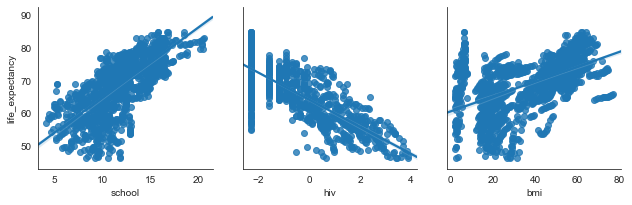

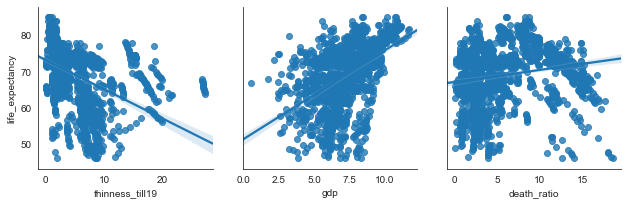

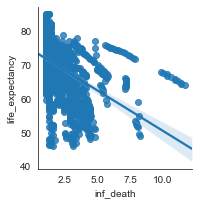

In [89]:
# after running the model again, more features became insignificant and we're dropped (pop_size)
depended = ['life_expectancy']
features = ['school', 'hiv', 'bmi', 'thinness_till19', 'gdp',
            'death_ratio', 'inf_death'] 

# looking at our data again to try and locate outliers
def get_pairs(data, row_groups, depended, features, n):
    row_groups = [features[i:i+n] for i in range(0, len(features), n)]

    for ind in row_groups:
        plot = sns.pairplot(x_vars=ind, y_vars=depended, data=data, kind="reg", height=3)
    return

get_pairs(new_df, row_groups, depended, features, 3)
new_df.shape

,life_expectancy,alcohol,bmi,hiv,gdp,thinness_till19,inf_death,school,death_ratio,lifestyle,pop_gdp,pop_size
0,65.0,0.01,19.1,-2.302585,6.370345,17.2,3.957892,10.1,2.059596,0.191,7.468957,3
1,59.9,0.01,18.6,-2.302585,6.417870,17.5,4.000000,10.0,2.057760,0.186,6.417870,1
2,59.9,0.01,18.1,-2.302585,6.448486,17.7,4.041240,9.9,2.015095,0.181,7.547098,3
3,59.5,0.01,17.6,-2.302585,6.507217,17.9,4.101566,9.8,1.985454,0.176,7.200364,2
4,59.2,0.01,17.2,-2.302585,4.151626,18.2,4.140818,9.5,1.968055,0.172,4.844773,2


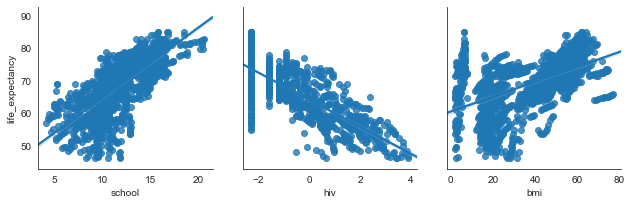

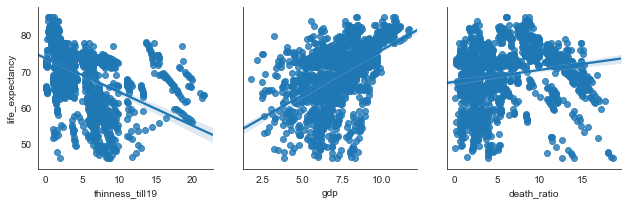

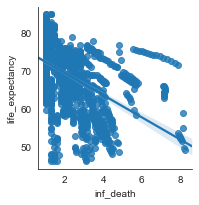

In [90]:
# remove outliers and check the amount of data that we left
new_df = new_df[new_df.gdp > 1.25] 
new_df = new_df[new_df.thinness_till19 < 25]

get_pairs(new_df, row_groups, depended, features, 3)
new_df.shape
new_df.head()

In [50]:
# running the model after removing the outlier
id_lr_model = ols(formula='life_expectancy~hiv+gdp+bmi+thinness_till19+inf_death+school+death_ratio', data=new_df).fit()
id_lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     738.5
Date:                Thu, 22 Aug 2019   Prob (F-statistic):               0.00
Time:                        10:53:57   Log-Likelihood:                -4151.6
No. Observations:                1513   AIC:                             8319.
Df Residuals:                    1505   BIC:                             8362.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          55.8474      0.825     67.661      0.000      54.228      57.466
hiv                -2.7556      0.073    -37.680      0.000      -2.899      -2.612
bmi                 0.0116      0.007      1.720      0.086      -0.002       0.025
gdp                 0.3371      0.073      4.621      0.000       0.194       0.480
thinness_till19    -0.1189      0.028     -4.189      0.000      -0.175      -0.063
inf_death          -0.9716      0.109     -8.902      0.000      -1.186      -0.758
school              0.8939      0.054     16.586      0.000       0.788       1.000
death_ratio        -0.1819      0.030     -6.097      0.000      -0.240      -0.123
==============================================================================
Omnibus:                       17.442   Durbin-Watson:                   0.431
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.712
Skew:                          -0.167   Prob(JB):                     1.93e-05
Kurtosis:                       3.483   Cond. No.                         384.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
# removing bmi and testing our model
X = new_df[['hiv','bmi', 'death_ratio','school','gdp', 'thinness_till19', 'inf_death']].values
y = new_df.life_expectancy.values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [101]:
print(model.intercept_)
print(model.coef_)

[55.25850054]
[[-2.85659356  0.00941479 -0.19522203  0.87046239  0.48337074 -0.11943831
  -1.00932607]]


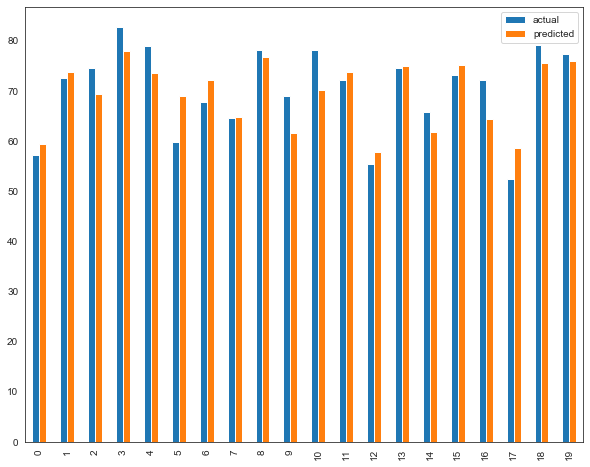

In [102]:
y_predict = model.predict(x_test)
predict_df = pd.DataFrame({'actual': y_test.flatten(), 'predicted': y_predict.flatten()})
plot_df = predict_df.head(20)
plot_df.plot(kind='bar', figsize=(10,8))

In [103]:
print('mean absolete error:', metrics.mean_absolute_error(y_test, y_predict))
print('mean squared error:', metrics.mean_squared_error(y_test, y_predict))
print('root squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

mean absolete error: 2.856767990559526
mean squared error: 13.904908906116399
root squared error: 3.7289286539321718
